In [1]:
import torch
import numpy as np
import os
from torchvision.io import read_image
import os
import matplotlib.pyplot as plt
import scipy.io
import h5py
import cv2
from spectral import *
from utils import Loss_Fid, Loss_SAM, Loss_SSIM, reconRGB, bgr2rgb
import hyperspy.api as hs

cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda else "cpu")
ROOT = '/work3/s212645/Spectral_Reconstruction'

TRAIN_RGB = '/Train_RGB/'
TRAIN_SP = '/Valid_Spec/'
device

device(type='cpu')

In [5]:
import scipy.io
import re

spec = '/work3/s212645/Spectral_Reconstruction/FakeHyperSpectrum/CVAE/'
f = os.listdir(spec)
len(f)
for i in range(len(f)):
    num = str(i).zfill(3)
    name = num + '.mat'
    try:
        with h5py.File(spec+name, 'r') as mat:
            scipy.io.savemat(spec+name, mat)
    except:
        mat = scipy.io.loadmat(spec+name)
        scipy.io.savemat(spec+name, mat)

In [ ]:
import torch.nn as nn
from torchmetrics.image.fid import FrechetInceptionDistance
class Loss_Fid(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.fid = FrechetInceptionDistance(feature=2048)
        
    def forward(self, outputs, label):
        outputs = outputs * 255
        label = label * 255
        outputs = outputs.type(torch.ByteTensor)
        label = label.type(torch.ByteTensor)
        self.fid.update(label, real=True)
        self.fid.update(outputs, real=False)
        fidscore = self.fid.compute()
        return fidscore

In [ ]:
with h5py.File(spec, 'r') as mat:
    hyper =np.float32(np.array(mat['cube']))
hyper = np.transpose(hyper, [2, 1, 0])
subhyper = cv2.resize(hyper, [128, 128])
print(subhyper.shape)
rgb = get_rgb(subhyper, (29, 19, 9)) # fid score
plt.imshow(rgb)
# indices = [22, 12, 3]
# subhyper = hyper[indices]
# subhyper = np.transpose(subhyper, [2, 1, 0])
# subhyper = cv2.cvtColor(subhyper, cv2.COLOR_BGR2RGB)
# subhyper = np.float32(subhyper)
# subhyper = (subhyper-subhyper.min())/(subhyper.max()-subhyper.min())
# plt.imshow(subhyper)
# view = ImageView()
# view.set_data(hyper, (29, 19, 9)) # fid score
# # view.set_data(hyper, (20, 13, 9)) # sam
# plt.imshow(view.data_rgb)
# subhyper = torch.tensor(view.data_rgb.transpose(2, 0, 1), dtype=torch.float32).to(device)
# sam = Loss_SAM().to(device)
# fid = Loss_Fid().to(device)
# lossmin = 1e12
# argi = 0
# argj = 1
# argk = 2

# loss = fid(bgr.reshape(8, 3, 482 // 2, 512 // 4), subhyper.reshape(8, 3, 482 // 2, 512 // 4))
# # print(subhyper)
# for i in range(0,10):
#     for j in range(10,20):
#         for k in range(20, 31):
#             view.set_data(hyper, (k, j, i))
#             subhyper = torch.tensor(view.data_rgb.transpose(2, 0, 1), dtype=torch.float32).to(device)
#             loss = fid(bgr.reshape(8, 3, 482 // 2, 512 // 4), subhyper.reshape(8, 3, 482 // 2, 512 // 4))
#             if loss < lossmin:
#                 lossmin = loss
#                 argi = i
#                 argj = j
#                 argk = k
#                 print(loss)

In [ ]:
path = '/work3/s212645/Spectral_Reconstruction/ICVL/data/mat/4cam_0411-1640-1.mat'
with h5py.File(path, 'r') as mat:
    hyper = np.float32(np.array(mat['rad']))
    rgb = np.float32(np.array(mat['rgb']))
hyper = np.transpose(hyper, [1, 2, 0])
hyper = np.flip(hyper, 0)
rgb = np.transpose(rgb, [2, 1, 0])
rgb = np.flip(rgb, 2)
# view = ImageView()
rgb = get_rgb(hyper, (29, 19, 9)) # fid score
plt.imshow(rgb)

In [ ]:
plt.imshow(rgb)

In [ ]:
names = []
for path, dirs, files in os.walk(ROOT+TRAIN_SP):
    for file in files:
        num_video = os.path.basename(path)
        names.append(os.path.basename(os.path.dirname(path)))
        hyper_path = os.path.join(path,file)
        with h5py.File(hyper_path, 'r') as mat:
            hyper =np.float32(np.array(mat['cube']))
        hyper = np.transpose(hyper, [2, 1, 0])
        imshow(hyper, (22, 10, 3))
        break

In [ ]:
names = []
for path, dirs, files in os.walk(ROOT+TRAIN_RGB):
    for file in files:
        num_video = os.path.basename(path)
        names.append(os.path.basename(os.path.dirname(path)))
        hyper_path = os.path.join(path,file)
        bgr_path = os.path.join(path,file)
        bgr = cv2.imread(bgr_path)
        bgr2rgb = True
        if bgr2rgb:
            bgr = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
        bgr = np.float32(bgr)
        bgr = (bgr-bgr.min())/(bgr.max()-bgr.min())
        bgr = np.transpose(bgr, [2, 0, 1])  # [3,482,512]
        
        stride = 8
        crop_size = 128
        idx = 0
        
        h,w = 482,512  # img shape
        patch_per_line = (w-crop_size)//stride+1
        patch_per_colum = (h-crop_size)//stride+1
        patch_per_img = patch_per_line*patch_per_colum
        img_idx, patch_idx = idx//patch_per_img, idx%patch_per_img
        h_idx, w_idx = patch_idx//patch_per_line, patch_idx%patch_per_line
        img = bgr[:,h_idx*stride:h_idx*stride+crop_size, w_idx*stride:w_idx*stride+crop_size]
        
        img = img.transpose(1,2,0)
        print(img.shape)
        plt.imshow(bgr.transpose(1,2,0))
        
        break

In [ ]:
outputs = torch.randn([64,31,128,128])
label = torch.randn_like(outputs)
error = torch.abs(outputs.view(-1) - label.view(-1)) / label.view(-1)
# mrae = torch.mean(error.reshape(-1))
mrae = torch.mean(error.view(-1))
mrae
a = np.array([0,1,1])
print(a.all())

In [ ]:
import torch.nn.functional as F
recons = torch.randn(1, 31, 128, 128)
input = torch.randn_like(recons)
mu = torch.randn(1, 1024)
log_var = torch.randn_like(mu)

kld_weight = 1024 / 128 / 128 / 31 # Account for the minibatch samples from the dataset
recons_loss =F.mse_loss(recons, input)

kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)
print(recons_loss, kld_loss * kld_weight) 

In [ ]:
import torch

import matplotlib.pyplot as plt


def window_partition(x, window_size):
    """
    Args:
        x: (B, H, W, C)
        window_size (int): window size

    Returns:
        windows: (num_windows*B, window_size, window_size, C)
    """
    B, H, W, C = x.shape
    x = x.view(B, H // window_size, window_size, W // window_size, window_size, C)
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size, window_size, C)
    return windows


window_size = 4
shift_size = 3
H, W = 16, 16
img_mask = torch.zeros((1, H, W, 1))  # 1 H W 1
h_slices = (slice(0, -window_size),
            slice(-window_size, -window_size * 2),
            slice(-window_size * 2, -window_size * 3),
            slice(-window_size * 3, -shift_size),
            slice(-shift_size, None))
w_slices = (slice(0, -window_size),
            slice(-window_size, -window_size * 2),
            slice(-window_size * 2, -window_size * 3),
            slice(-window_size * 3, -shift_size),
            slice(-shift_size, None))
cnt = 0
for h in h_slices:
    for w in w_slices:
        img_mask[:, h, w, :] = cnt
        cnt += 1

mask_windows = window_partition(img_mask, window_size)  # nW, window_size, window_size, 1
mask_windows = mask_windows.view(-1, window_size * window_size)

attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))

plt.matshow(img_mask[0, :, :, 0].numpy())
for i in range(16):
    plt.matshow(attn_mask[i].numpy())

plt.show()

In [ ]:
import sys
sys.path.append('./')
from torch.utils.data import Dataset
import numpy as np
import random
import cv2
import h5py
from torch.utils.data import DataLoader
from torch.autograd import Variable
import os
import torch
import torch.nn as nn
import scipy.io
import re
import matplotlib.pyplot as plt

root = '/work3/s212645/Spectral_Reconstruction/'
datanames = ['ICVL/', 'ARAD/', 'CAVE/']

def Rename(path):
    filelist = os.listdir(path)
    reg = re.compile(r'.*.mat')
    for file in filelist:
        if re.findall(reg, file):
            oldname = path + file
            number = file.split('.mat')[0]
            newnumber = number.zfill(3)
            newname = path + newnumber + '.mat'
            os.rename(oldname, newname)

def gen_test_list(matlist, startidx, size):
    testlist = []
    for i in range(size):
        testlist.append(matlist[i + startidx])
    return testlist

def cross_validation_lists(path, test_size):
    crossvaltrainlists = []
    crossvaltestlists = []
    filelist = os.listdir(path)
    filelist.sort()
    assert len(filelist) > test_size
    reg = re.compile(r'.*.mat')
    matlist = []
    for file in filelist:
        if re.match(reg, file):
            matlist.append(file)
    matlist.sort()
    all_length = len(matlist)
    assert all_length % test_size == 0
    for i in range(all_length // test_size):
        trainlist = []
        testlist = []
        testlist = gen_test_list(matlist, i * test_size, test_size)
        trainlist = matlist.copy()
        for mat in testlist:
            trainlist.remove(mat)
        crossvaltestlists.append(testlist)
        crossvaltrainlists.append(trainlist)
    return crossvaltrainlists, crossvaltestlists

def cross_validation_dataset(path, test_size, imsize):
    train_sets = []
    test_sets = []
    crossvaltrainlists, crossvaltestlists = cross_validation_lists(path, test_size)
    num_crossval = len(crossvaltrainlists)
    for i in range(num_crossval):
        train_sets.append(get_dataset(crossvaltrainlists[i], imsize))
        test_sets.append(get_dataset(crossvaltestlists[i], imsize))
    return train_sets, test_sets

def get_dataset(list, imsize):
    specs, rgbs = get_all_mats(list, imsize)
    return specs, rgbs

def split_train_test(path, test_size, imsize):
    filelist = os.listdir(path)
    filelist.sort()
    assert len(filelist) > test_size
    reg = re.compile(r'.*.mat')
    matlist = []
    for file in filelist:
        if re.match(reg, file):
            matlist.append(file)
    all_length = len(matlist)
    train_size = all_length - test_size
    matlist.sort()
    trainlist = []
    testlist = []
    for i in range(train_size):
        trainlist.append(matlist[i])
    for j in range(test_size):
        testlist.append(matlist[j + train_size])
    train_sets = get_dataset(trainlist, imsize)
    test_sets = get_dataset(testlist, imsize)
    return train_sets, test_sets

def get_all_mats(filelist, imsize):
    specs = []
    rgbs = []
    for file in filelist:
        mat = scipy.io.loadmat(path+file)
        spec, rgb = get_all_patches(mat, imsize)
        specs += spec
        rgbs += rgb
        break
    return specs, rgbs
    
def Resize(hyper, rgb, h, w):
    hyper_s = cv2.resize(hyper, [h, w])
    rgb_s = cv2.resize(rgb, [h, w])
    return hyper_s, rgb_s

def data_resize(mat, imsize):
    spectral_images = []
    rgb_images = []
    hyper = np.float32(np.array(mat['cube']))
    rgb = np.float32(np.array(mat['rgb']))
    h = rgb.shape[0]
    w = rgb.shape[1]
    while min(h // imsize, w // imsize) >= 1:
        hyper_s, rgb_s = Resize(hyper, rgb, h, w)
        spectral_images.append(hyper_s)
        rgb_images.append(rgb_s)
        h = h // 2
        w = w // 2
    if h > imsize / 2 or w > imsize / 2 :
        hyper_s, rgb_s = Resize(hyper, rgb, imsize, imsize)
        spectral_images.append(hyper_s)
        rgb_images.append(rgb_s)
    return spectral_images, rgb_images

def patch_gen(array, imsize, h, w):
    return array[h-imsize:h, w-imsize:w, :]

def patch_image(array, imsize):
    h = array.shape[0]
    w = array.shape[1]
    assert h >= imsize
    assert w >= imsize
    iter_h = int(np.ceil(h / imsize) + 1)
    iter_w = int(np.ceil(w / imsize) + 1)
    patches = []
    for i in range(1, iter_h):
        for j in range(1, iter_w):
            patches.append(patch_gen(array, imsize, min(h, i * imsize), min(w, j * imsize)))
    return patches
    
def get_all_patches(mat, imsize):
    spectrals = []
    rgbs = []
    resize_spectrals, resize_rgbs = data_resize(mat, imsize)
    for i in range(len(resize_spectrals)):
        hyperpatches = patch_image(resize_spectrals[i], imsize)
        rgbpatches = patch_image(resize_rgbs[i], imsize)
        spectrals += hyperpatches
        rgbs += rgbpatches
    return spectrals, rgbs

if __name__ == '__main__':
    path = root + datanames[0]
    # spectral_images, rgb_images = get_all_mats(path, 128)
    # print(len(rgb_images))
    # print(rgb_images[-1].shape)
    train_sets, test_sets = split_train_test(path, 1, 128)
    print(len(train_sets[0]))
    print(sys.getsizeof(train_sets))
    plt.imshow(train_sets[1][-1])

In [ ]:
from dataset.dataset import TrainDataset, ValidDataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

root = '/work3/s212645/Spectral_Reconstruction/'
datanames = ['ICVL/']
# datanames = ['ICVL/', 'ARAD/', 'CAVE/']
trainset = ValidDataset(root, 128, 0.02)
print(len(trainset))
train_loader = DataLoader(dataset=trainset, batch_size=1, shuffle=False, num_workers=2, drop_last=False)

for i, (image, label) in enumerate(train_loader):
    image = image.squeeze(0)
    image = image.permute([1,2,0])
    print(image.shape)
    plt.imshow(image.cpu().numpy())
    plt.imshow(image.cpu().numpy())
    image = image.reshape(-1).cpu().numpy()
    print(np.max(image), np.min(image))
    label = label.reshape(-1).cpu().numpy()
    print(np.max(label), np.min(label))
    break

In [ ]:
import numpy as np
import math
import torch
import torch.nn as nn

def SAM(s1, s2):
    b,c,h,w = s1.shape
    num_pix = h * w * c / 31
    s1 = s1.reshape(-1)
    s2 = s2.reshape(-1)
    try:
        s1_norm = torch.sqrt(torch.dot(s1, s1))
        s2_norm = torch.sqrt(torch.dot(s2, s2))
        sum_s1_s2 = torch.dot(s1, s2)
        angle = torch.acos(sum_s1_s2 / (s1_norm * s2_norm)) / num_pix
    except ValueError:
        # python math don't like when acos is called with
        # a value very near to 1
        return 0.0
    return angle


def SID(s1, s2):
    b = s1.shape[0]
    s1 = s1.view(b, -1)
    s2 = s2.view(b, -1)
    s1 = nn.Sigmoid()(s1)
    s2 = nn.Sigmoid()(s2)
    p = (s1 / torch.sum(s1)) + torch.finfo(torch.float).eps
    q = (s2 / torch.sum(s2)) + torch.finfo(torch.float).eps
    return torch.mean(torch.sum(p * torch.log(p / q) + q * torch.log(q / p), dim=1).view(-1))

# s1 = np.random.normal(0, 1, [128,128,31])
# s2 = np.random.normal(0, 1, [128,128,31])
s1 = torch.randn([2, 31, 128, 128])
s2 = torch.randn([2, 31, 128, 128])
# s1 = nn.Tanh()(s1)
# s2 = nn.Tanh()(s2)
# s2 = s1 * 0.2
sam = SAM(s1, s2)
sam

In [ ]:
# rename
import os
import re
imgpath = '/work3/s212645/Spectral_Reconstruction/ICVL/'

def Rename(path):
    i = 1
    filelist = os.listdir(path)
    reg = re.compile(r'.*.mat')
    for file in filelist:
        if re.findall(reg, file):
            oldname = path + file
            # number = file.split('.mat')[0]
            number = str(i)
            newnumber = number.zfill(3)
            i += 1 
            newname = path + newnumber + '.mat'
            os.rename(oldname, newname)

Rename(imgpath)

In [ ]:
import os
import re
import cv2
import h5py
import scipy.io
specpath = '/work3/s212645/Spectral_Reconstruction/Train_Spec/'
rgbpath = '/work3/s212645/Spectral_Reconstruction/Train_RGB/'

savepath = '/work3/s212645/Spectral_Reconstruction/ARAD/'
allname = 'ARAD_1K_'
for i in range(950):
    i = i + 1
    mat = {}
    number = str(i).zfill(4)
    specname = allname + number + '.mat'
    rgbname = allname + number + '.jpg'
    hyper_path = specpath + specname
    with h5py.File(hyper_path, 'r') as MAT:
        hyper =np.float32(np.array(MAT['cube']))
    mat['cube'] = np.transpose(hyper, [1, 2, 0])
    bgr = cv2.imread(rgbpath + rgbname)
    bgr = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    bgr = np.float32(bgr)
    bgr = (bgr-bgr.min())/(bgr.max()-bgr.min())
    # bgr = np.transpose(bgr, [2, 0, 1])  # [3,482,512]
    mat['rgb'] = bgr
    newname = str(i).zfill(3) + '.mat'
    scipy.io.savemat(savepath+newname, mat)
    print(savepath+newname, ' saved')

In [23]:
import os
import re
import cv2
import h5py
import scipy.io

savepath = '/work3/s212645/Spectral_Reconstruction/ARAD/'
# matname = '/work3/s212645/Spectral_Reconstruction/ARAD_1K_0027.mat'
# jpgname = '/work3/s212645/Spectral_Reconstruction/ARAD_1K_0027.jpg'
# mat = {}
# with h5py.File(matname, 'r') as MAT:
#     hyper =np.float32(np.array(MAT['cube']))
# mat['cube'] = np.transpose(hyper, [1,2,0])
# print(mat['cube'].shape)
# bgr = cv2.imread(jpgname)
# bgr = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
# bgr = np.float32(bgr)
# bgr = (bgr-bgr.min())/(bgr.max()-bgr.min())
# mat['rgb'] = bgr
# newname = str(27).zfill(3) + '.mat'
# scipy.io.savemat(savepath+newname, mat)



for i in range(950):
    j = i + 1
    mat = {}
    number = str(j).zfill(3)
    specname = number + '.mat'
    hyper_path = savepath + specname
    mat = scipy.io.loadmat(hyper_path)
    hyper =np.float32(np.array(mat['cube']))
    mat['cube'] = np.transpose(hyper, [1,0,2])
    print(mat['cube'].shape)
    newname = str(j).zfill(3) + '.mat'
    scipy.io.savemat(savepath+newname, mat)
    print(savepath+newname, ' saved')

(482, 512, 31)
/work3/s212645/Spectral_Reconstruction/ARAD/001.mat  saved
(482, 512, 31)
/work3/s212645/Spectral_Reconstruction/ARAD/002.mat  saved
(482, 512, 31)
/work3/s212645/Spectral_Reconstruction/ARAD/003.mat  saved
(482, 512, 31)
/work3/s212645/Spectral_Reconstruction/ARAD/004.mat  saved
(482, 512, 31)
/work3/s212645/Spectral_Reconstruction/ARAD/005.mat  saved
(482, 512, 31)
/work3/s212645/Spectral_Reconstruction/ARAD/006.mat  saved
(482, 512, 31)
/work3/s212645/Spectral_Reconstruction/ARAD/007.mat  saved
(482, 512, 31)
/work3/s212645/Spectral_Reconstruction/ARAD/008.mat  saved
(482, 512, 31)
/work3/s212645/Spectral_Reconstruction/ARAD/009.mat  saved
(482, 512, 31)
/work3/s212645/Spectral_Reconstruction/ARAD/010.mat  saved
(482, 512, 31)
/work3/s212645/Spectral_Reconstruction/ARAD/011.mat  saved
(482, 512, 31)
/work3/s212645/Spectral_Reconstruction/ARAD/012.mat  saved
(482, 512, 31)
/work3/s212645/Spectral_Reconstruction/ARAD/013.mat  saved
(482, 512, 31)
/work3/s212645/Spectral

In [ ]:
i = 26
j = i + 1
mat = {}
number = str(j).zfill(3)
specname = number + '.mat'
hyper_path = savepath + specname
mat = scipy.io.loadmat(hyper_path)
hyper =np.float32(np.array(mat['cube']))
mat['cube'] = np.transpose(hyper, [1,0,2])
print(mat['cube'].shape)
newname = str(j).zfill(3) + '.mat'
scipy.io.savemat(savepath+newname, mat)
print(savepath+newname, ' saved')

In [ ]:
import os
import re
import cv2
import h5py
import numpy as np
import scipy.io

savepath = '/work3/s212645/Spectral_Reconstruction/ARAD/'
for i in range(950):
    i = i + 1
    mat = {}
    number = str(i).zfill(3)
    specname = number + '.mat'
    hyper_path = savepath + specname
    mat = scipy.io.loadmat(hyper_path)
    hyper =np.float32(np.array(mat['cube']))
    if np.min(hyper) < 0:
        print('find data error at ', number)
        print(np.min(hyper), np.max(hyper))
        hyper = (hyper - np.min(hyper)) / (np.max(hyper) - np.min(hyper))
        mat['cube'] = hyper
        newname = str(i).zfill(3) + '.mat'
        scipy.io.savemat(savepath+newname, mat)
        print(savepath+newname, ' saved')
    if np.max(hyper) > 1:
        print('find data error at ', number)
        print(np.min(hyper), np.max(hyper))
        hyper = (hyper - np.min(hyper)) / (np.max(hyper) - np.min(hyper))
        mat['cube'] = hyper
        newname = str(i).zfill(3) + '.mat'
        scipy.io.savemat(savepath+newname, mat)
        print(savepath+newname, ' saved')

In [ ]:
import os
import re
import cv2
import h5py
specpath = '/work3/s212645/Spectral_Reconstruction/ICVL/'

savepath = '/work3/s212645/Spectral_Reconstruction/ICVL_Norm/'
for i in range(201):
    i = i + 1
    mat = {}
    number = str(i).zfill(3)
    specname = number + '.mat'
    hyper_path = specpath + specname
    # with h5py.File(hyper_path, 'r') as MAT:
    #     hyper =np.float32(np.array(MAT['cube']))
    mat = scipy.io.loadmat(hyper_path)
    hyper = mat['cube']
    hyper = np.float32(hyper)
    hyper = (hyper-hyper.min())/(hyper.max()-hyper.min())
    mat['cube'] = hyper
    print(mat['cube'].shape)
    print(mat['rgb'].shape)
    newname = str(i).zfill(3) + '.mat'
    scipy.io.savemat(savepath+newname, mat)
    print(savepath+newname, ' saved')

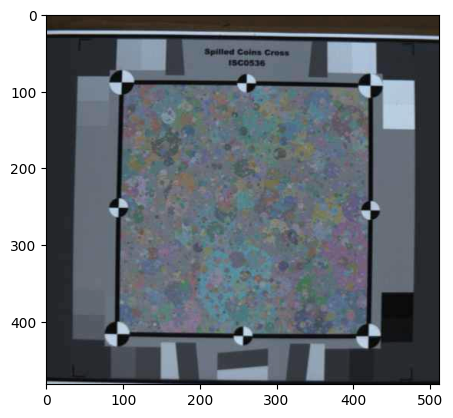

In [26]:
import os
import re
import cv2
import h5py
import matplotlib.pyplot as plt
from spectral import *
specpath = '/work3/s212645/Spectral_Reconstruction/ARAD/'

# specpath = '/work3/s212645/Spectral_Reconstruction/ICVL_Norm/'

i = 900
number = str(i).zfill(3)
specname = number + '.mat'
hyper_path = specpath + specname
mat = scipy.io.loadmat(hyper_path)
hyper = mat['cube']
rgb = mat['rgb']
plt.imshow(rgb)

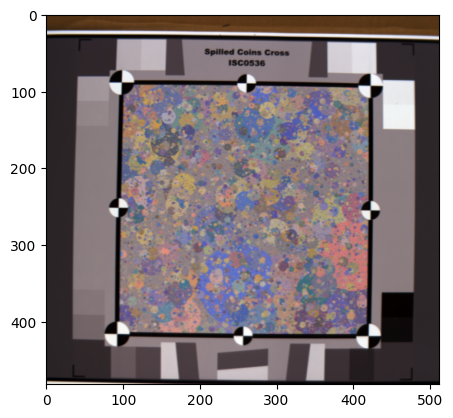

In [27]:

rgb = get_rgb(hyper, (29, 19, 9))
plt.imshow(rgb)